In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(-0.5, 4675.5, 4674.5, -0.5)

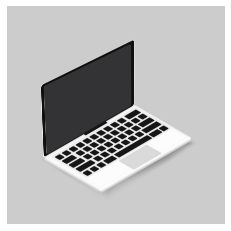

In [2]:
# read RGB image 
img = cv2.cvtColor(cv2.imread('laptop_black.jpg'), cv2.COLOR_BGR2RGB)

# plot image
plt.imshow(img)
plt.axis('off')

In [3]:
# Definie source triangle
A = [int(img.shape[1]/3), int(img.shape[0]/4)]
B = [int(img.shape[1]*3/4), int(img.shape[0]/2)]
C = [int(img.shape[1]/2), int(img.shape[0]/4*3)]
src_anotation_label = ['A', 'B', 'C']
src_triangle = np.array([A, B, C])

In [4]:
def plot_triangle_with_labels(img, triangle, anotation_label, fill = True, ax = plt):
    
    # plot image
    ax.imshow(img)
    
    # fill triangle
    if fill:
        ax.fill_between(np.concatenate((triangle[:,0], [triangle[:,0][0]])), 
                         np.concatenate((triangle[:,1], [triangle[:,1][0]])), alpha = 0.5)
        
    # annotate triangle
    ax.scatter(triangle[:,0], triangle[:,1], color = 'tab:orange' )
    for i, txt in enumerate(anotation_label):
        ax.annotate(txt, (triangle[:,0][i], triangle[:,1][i]), bbox=dict(boxstyle='circle, pad=0.2', fc='white', alpha=0.7),)
    ax.axis('off')

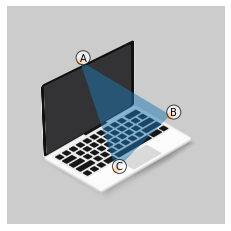

In [5]:
# plot source triangle
plot_triangle_with_labels(img, src_triangle, src_anotation_label)

In [6]:
# Definie destination triangle
A_prim = [0, int(img.shape[0]/2)]
B_prim = [int(img.shape[1]*4/5), int(img.shape[0]/3)]
C_prim = [int(img.shape[1]/2), int(img.shape[0]*4/5)]
dst_anotation_label = ["A'", "B'","C'",]
dst_triangle = np.array([A_prim, B_prim, C_prim])

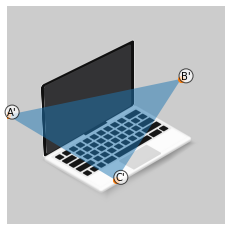

In [7]:
# plot destination triangle
plot_triangle_with_labels(img, dst_triangle, dst_anotation_label)

In [8]:
# Find the minimal up-right bounding rectangle for definted triangle
bounding_source_rectangle = cv2.boundingRect(np.float32([src_triangle]))

In [9]:
bounding_source_rectangle

(1558, 1168, 1950, 2339)

In [10]:
# Find image bounded by bounding_rectangle
img_bounded_by_source_rectangle = img[bounding_source_rectangle[1]:bounding_source_rectangle[1] + bounding_source_rectangle[3],
                   bounding_source_rectangle[0]:bounding_source_rectangle[0] + bounding_source_rectangle[2]]

In [11]:
# Because we will consider only bounding_rectangle possition, let's change triangle corridanates 
src_triangle_in_bounding_rectangle = []
for i in range(0, 3):
    src_triangle_in_bounding_rectangle.append(((src_triangle[i][0] - bounding_source_rectangle[0]),
                                               (src_triangle[i][1] - bounding_source_rectangle[1])))

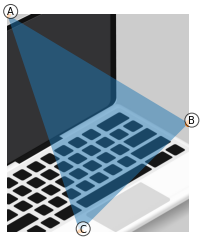

In [12]:
# plot bounded image with source triangle
plot_triangle_with_labels(img_bounded_by_source_rectangle, np.array(src_triangle_in_bounding_rectangle), src_anotation_label)

In [13]:
# create RGB mask of maxium size of bounding_rectangle. 
src_mask = np.zeros((bounding_source_rectangle[3], bounding_source_rectangle[2], 3), dtype = np.float32) 

# Fill triangle in mask
cv2.fillConvexPoly(src_mask, np.int32(src_triangle_in_bounding_rectangle), (1, 1, 1));

(-0.5, 1949.5, 2338.5, -0.5)

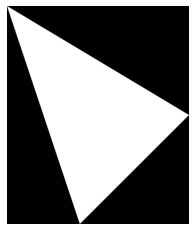

In [14]:
plt.imshow(src_mask)
plt.axis('off')

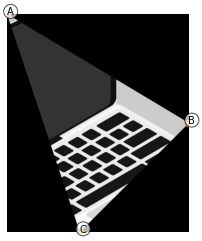

In [15]:
# plot mask
bounded_triangle = (src_mask * img_bounded_by_source_rectangle).astype(int)
plot_triangle_with_labels(bounded_triangle, np.array(src_triangle_in_bounding_rectangle), src_anotation_label, fill = False)

In [16]:
# Find bounded destination triangle

bounding_destination_rectangle = cv2.boundingRect(np.float32([dst_triangle]))
img_bounded_by_destination_rectangle = img[bounding_destination_rectangle[1]:bounding_destination_rectangle[1] + bounding_destination_rectangle[3],
                   bounding_destination_rectangle[0]:bounding_destination_rectangle[0] + bounding_destination_rectangle[2]]

dst_triangle_in_bounding_rectangle = []
for i in range(0, 3):
    dst_triangle_in_bounding_rectangle.append(((dst_triangle[i][0] - bounding_destination_rectangle[0]),
                                               (dst_triangle[i][1] - bounding_destination_rectangle[1])))

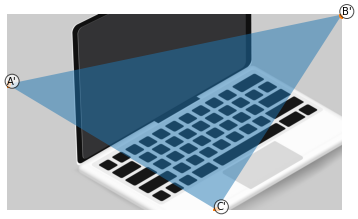

In [17]:
# plot bounded image with destination triangle
plot_triangle_with_labels(img_bounded_by_destination_rectangle, 
                          np.array(dst_triangle_in_bounding_rectangle), dst_anotation_label)

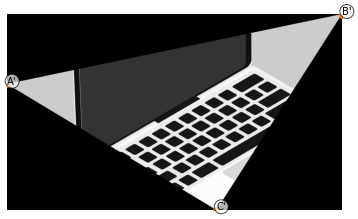

In [18]:
# create RGB mask of maxium size of bounding_rectangle. 
dst_mask = np.zeros((bounding_destination_rectangle[3], bounding_destination_rectangle[2], 3), dtype = np.float32) 

# Fill triangle in mask
cv2.fillConvexPoly(dst_mask, np.int32(dst_triangle_in_bounding_rectangle), (1, 1, 1));

# plot mask
dst_bounded_triangle = (dst_mask * img_bounded_by_destination_rectangle).astype(int)
plot_triangle_with_labels(dst_bounded_triangle, np.array(dst_triangle_in_bounding_rectangle), dst_anotation_label, fill = False)

In [19]:
# define geometric transformation which preserves collinearity
def affine_transform(src_img, src_triangle, dst_triangle, size) :
    
    # find the affine transform.
    warpMat = cv2.getAffineTransform( np.array(src_triangle).astype(np.float32), np.array(dst_triangle).astype(np.float32) )
    
    # apply the Affine Transform 
    output_img = cv2.warpAffine( src_img, warpMat, (size[0], size[1]))

    return output_img

In [20]:
# transform source triangle into destination triangle
warpImage_dest_to_src = affine_transform(img_bounded_by_destination_rectangle, 
                                  dst_triangle_in_bounding_rectangle,
                                  src_triangle_in_bounding_rectangle, 
                                  (bounding_source_rectangle[2], bounding_source_rectangle[3]))

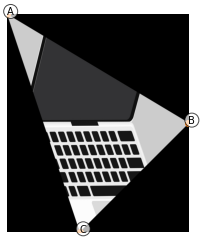

In [21]:
# plot transformed triangle
plot_triangle_with_labels((warpImage_dest_to_src * src_mask).astype(int),
                          np.array(src_triangle_in_bounding_rectangle),
                          src_anotation_label, fill = False)

In [22]:
# transform destination triangle into source triangle
warpImage_src_to_dest = affine_transform(img_bounded_by_source_rectangle, 
                                  src_triangle_in_bounding_rectangle, 
                                  dst_triangle_in_bounding_rectangle,
                                  (bounding_destination_rectangle[2], bounding_destination_rectangle[3]))

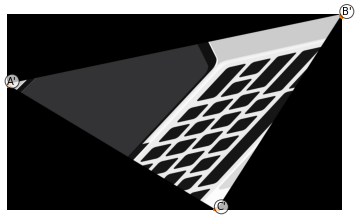

In [23]:
# plot transformed triangle
plot_triangle_with_labels((warpImage_src_to_dest * dst_mask).astype(int),
                          np.array(dst_triangle_in_bounding_rectangle),
                          dst_anotation_label, fill = False)

In [24]:
# to concatenate two images, first lets copy original image to not overwrite it.
concatenated_img = img.copy()

# concatenate two images - replace source_rectangle with warpImage_dest_to_src, to replaced only triangle -- use src_mask
concatenated_img[bounding_source_rectangle[1]:bounding_source_rectangle[1] + bounding_source_rectangle[3],
                 bounding_source_rectangle[0]:bounding_source_rectangle[0] + bounding_source_rectangle[2]]  = img_bounded_by_source_rectangle * ( 1 - src_mask ) + warpImage_dest_to_src * src_mask

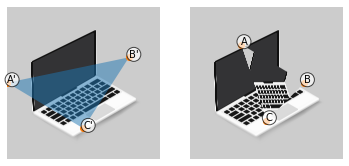

In [25]:
# Results
# We transform A', B', C' to A, B, C
f, ax = plt.subplots(1,2)
plot_triangle_with_labels(img, dst_triangle, dst_anotation_label, ax = ax[0])
plot_triangle_with_labels(concatenated_img, src_triangle, src_anotation_label, fill = False , ax = ax[1])

In [26]:
# sometimes we would like to overlap transformed triangle, that means 
# we do not want use only created warpImage_dest_to_src, but also original original_bounded_img

# definie alpha which allows you to see both
alpha = 0.5 

overlapping_img = ((1.0 - alpha) * (img_bounded_by_source_rectangle * src_mask.astype(int) ) + alpha * warpImage_dest_to_src * src_mask).astype(int)

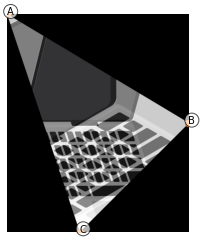

In [27]:
# plot overlapping img
plot_triangle_with_labels(overlapping_img,
                          np.array(src_triangle_in_bounding_rectangle),
                          src_anotation_label, fill = False , ax = plt)

In [28]:
# of course we can transform one image to another, to do that we will definie transform_triangle funtion

def transform_triangle(img1, img2, concatenated_img, src_triangle, dst_triangle, alpha = 0.5):
    # Find the minimal up-right bounding rectangle for both triangles
    bounding_source_rectangle = cv2.boundingRect(np.float32([src_triangle]))
    bounding_destination_rectangle = cv2.boundingRect(np.float32([dst_triangle]))

    # Find image bounded by bounding_rectangle
    img_bounded_by_source_rectangle = img1[bounding_source_rectangle[1]:bounding_source_rectangle[1] + bounding_source_rectangle[3],
                   bounding_source_rectangle[0]:bounding_source_rectangle[0] + bounding_source_rectangle[2]]
    img_bounded_by_destination_rectangle = img2[bounding_destination_rectangle[1]:bounding_destination_rectangle[1] + bounding_destination_rectangle[3],
                   bounding_destination_rectangle[0]:bounding_destination_rectangle[0] + bounding_destination_rectangle[2]]

    
    # Because we will consider only bounded rectangles possition, let's change triangles corridanates 
    src_triangle_in_bounding_rectangle = []
    dst_triangle_in_bounding_rectangle = []
    
    for i in range(0, 3):
        src_triangle_in_bounding_rectangle.append(((src_triangle[i][0] - bounding_source_rectangle[0]),
                                                   (src_triangle[i][1] - bounding_source_rectangle[1])))
        dst_triangle_in_bounding_rectangle.append(((dst_triangle[i][0] - bounding_destination_rectangle[0]),
                                               (dst_triangle[i][1] - bounding_destination_rectangle[1])))
        
    # create RGB mask of maxium size of bounding_rectangle. 
    src_mask = np.zeros((bounding_source_rectangle[3], bounding_source_rectangle[2], 3), dtype = np.float32) 

    # Fill triangle in mask
    cv2.fillConvexPoly(src_mask, np.int32(src_triangle_in_bounding_rectangle), (1, 1, 1));

    # define bounded triangle
    bounded_triangle = (src_mask * img_bounded_by_source_rectangle).astype(int)
    
    # transform source triangle into destination triangle
    warpImage_dest_to_src = affine_transform(img_bounded_by_destination_rectangle, 
                                  dst_triangle_in_bounding_rectangle,
                                  src_triangle_in_bounding_rectangle, 
                                  (bounding_source_rectangle[2], bounding_source_rectangle[3]))

    # create overlapping img
    overlapping_img = ((1.0 - alpha) * (img_bounded_by_source_rectangle ) + alpha * warpImage_dest_to_src).astype(int)

    # concatenate two images - replace source_rectangle with warpImage_dest_to_src, to replaced only triangle -- use src_mask
    concatenated_img[bounding_source_rectangle[1]:bounding_source_rectangle[1] + bounding_source_rectangle[3],
                     bounding_source_rectangle[0]:bounding_source_rectangle[0] + bounding_source_rectangle[2]]  = img_bounded_by_source_rectangle * ( 1 - src_mask ) + overlapping_img * src_mask
    
    return concatenated_img, warpImage_dest_to_src

In [29]:
img1 = cv2.cvtColor(cv2.imread('laptop_black.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('laptop_pink.jpg'), cv2.COLOR_BGR2RGB)

In [30]:
# Definie source triangle
A = [int(img.shape[1]/3), int(img.shape[0]/4)]
B = [int(img.shape[1]*3/4), int(img.shape[0]/2)]
C = [int(img.shape[1]/2), int(img.shape[0]/4*3)]
src_anotation_label = ['A', 'B', 'C']
src_triangle = np.array([A, B, C])

In [31]:
# Definie destination triangle
A_prim = [0, int(img.shape[0]/2)]
B_prim = [int(img.shape[1]*4/5), int(img.shape[0]/3)]
C_prim = [int(img.shape[1]/2), int(img.shape[0]*4/5)]
dst_anotation_label = ["A'", "B'","C'",]
dst_triangle = np.array([A_prim, B_prim, C_prim])

In [32]:
concatenated_img, warpImage_dest_to_src = transform_triangle(img1, img2, img1.copy(), src_triangle, dst_triangle, alpha = 0.5)

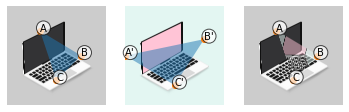

In [33]:
# We transform A', B', C' (img2) to A, B, C (img1)
f, ax = plt.subplots(1,3)
plot_triangle_with_labels(img1, src_triangle, src_anotation_label, ax = ax[0])
plot_triangle_with_labels(img2, dst_triangle, dst_anotation_label, ax = ax[1])
plot_triangle_with_labels(concatenated_img, src_triangle, src_anotation_label, fill = False, ax = ax[2])

# lET'S CHECK HOW AFFINE TRANSFORMATION WORKS ON laPa DATASET :)

In [ ]:
# import nessesary library

In [54]:
import sys
sys.path.append('../')
from src.dataset import read_folder
from src.visualization import plot_img

In [58]:
from ipynb.fs.full.triangulation import plot_landmarks_triplot
#

In [ ]:
# reload example images

In [48]:
# define Path
PATH = '../LaPa/examples'

In [49]:
# load few examples
images = read_folder(PATH, n = 10, landmarks= 'landmarks', RGB = True)

In [50]:
# Let's import example a mesh composed of triangles (it has been created in ../Triangulation/triangulation.ipynb) 
import pickle as pkl
with open('../Triangulation/symmetrical_traingles.pkl','rb') as f:
    symmetrical_traingles = pkl.load(f)

In [101]:
# let's choose two images
first_example_img = '7062399801_2' # first image is a base
second_example_img =  '7797532000_0' # second image presents person which will be transform into first person

In [103]:
img1 = images[first_example_img]['img']
img2 = images[second_example_img]['img']

# Let's chose example triangle [29,  80,  63] (it is a chin triangle)
src_triangle = images[first_example_img]['landmarks']()[[29,  80,  63]]
dst_triangle = images[second_example_img]['landmarks']()[[29,  80,  63]]

In [104]:
# transform [29,  80,  63] triangle from img2 to img1 with alpha = 1
concatenated_img, warpImage_dest_to_src = transform_triangle(img1, img2, img1.copy(), src_triangle, dst_triangle, alpha = 1)

In [105]:
def plot_triplot_ax(example_img, ax, symmetrical_traingles, red_triangle = False):
    plot_img(images[example_img]['img'], ax = ax)
    landmarks = images[example_img]['landmarks']()
    plot_landmarks_triplot(landmarks, symmetrical_traingles, without_img = False, ax = ax)
    
    if red_triangle is not False:
        ax.triplot(landmarks[:,0],
                   landmarks[:,1] * ((-1) ** False), np.array([red_triangle]), 
                                          '--', color = 'red')
    plt.tight_layout()

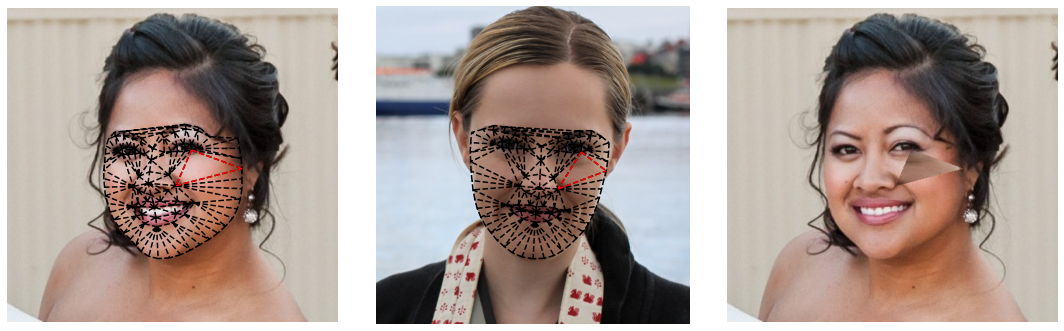

In [106]:
# see results!

f, ax = plt.subplots(1,3, figsize=(15,5))
                     
plot_triplot_ax(first_example_img, ax[0], symmetrical_traingles, red_triangle = [29,  80,  63])
plot_triplot_ax(second_example_img, ax[1], symmetrical_traingles, red_triangle = [29,  80,  63])

# plot first image with the 2nd image person's chin 
plot_img(concatenated_img, ax = ax[2])


In [122]:
# maybe it is not super effective, but if you would like to transform few traingles - 
# let's change triangle by triangle in the loop (later i will show you how to do it better):

def change_faces(first_example_img, second_example_img, symmetrical_traingles, alpha ):
    
    img1 = images[first_example_img]['img']
    img2 = images[second_example_img]['img']

    first_landmarks = images[first_example_img]['landmarks']()
    second_landmarks = images[second_example_img]['landmarks']()
    img_temp = img1
    n_triangles = len(symmetrical_traingles)
    for i in range(n_triangles):

        src_triangle = first_landmarks[symmetrical_traingles[i]]
        dst_triangle = second_landmarks[symmetrical_traingles[i]]

        concatenated_img, warpImage_dest_to_src = transform_triangle(img_temp, img2, img_temp.copy(), 
                                                                     src_triangle, dst_triangle, alpha = alpha)
        img_temp = concatenated_img
        
    return concatenated_img

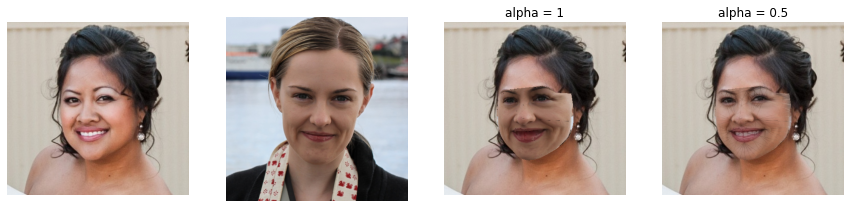

In [125]:
# Let's see results

f, ax = plt.subplots(1,4, figsize=(15,5))
                     
plot_img(img1, ax[0])
plot_img(img2, ax[1])

# plot first image with the 2nd image person's face 
plot_img(change_faces(first_example_img, second_example_img, symmetrical_traingles, 1), ax = ax[2], title = 'alpha = 1')
plot_img(change_faces(first_example_img, second_example_img, symmetrical_traingles, 0.5), ax = ax[3], title = 'alpha = 0.5')